# Footprint the extents of rasters

In [2]:
import rasterio as rio
import rasterio.features
import rasterio.warp
from rasterio.plot import show
from rasterio import Affine, MemoryFile
from rasterio.enums import Resampling

import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import box
import fiona
from fiona.crs import from_epsg
import pprint

import glob
import os
#import s3fs

import sys
sys.path.append('/efs/pmontesa/code/geoscitools')
sys.path.append('/home/pmontesa/code/geoscitools')
import maplib
import footprintlib
from footprintlib import *

import matplotlib.pyplot as plt

# https://gis.stackexchange.com/questions/375577/how-do-i-write-out-a-mixed-geometry-geodataframe-to-a-geopackage
# https://gis.stackexchange.com/questions/187877/how-to-polygonize-raster-to-shapely-polygons

# Set up dictionaries of parameters

#### Build a list of dictionarys with the params needed to footprint raster datasets
_TODO: clean this up a bit_

#### Footprint some DSM-diff'd CHMs 

In [4]:
%%time

TARGET_DIR = '/explore/nobackup/people/pmontesa/chm_work/hrsi_chm_sgm_filt'

print(TARGET_DIR)

f_list =glob.glob(f'{TARGET_DIR}/**/*sr05-max_dz_eul.tif')
f_gdf_lst = [footprintlib.raster_footprint(r_fn, DO_DATAMASK=False, GET_ONLY_DATASETMASK=False, R_READ_MODE='r', MANY_CRS=True) for r_fn in f_list]
footprint_gdf = footprintlib.build_footprint_db(f_gdf_lst, TO_GCS=False, WRITE_GPKG=False, OUT_F_NAME='', OUT_LYR_NAME='sr05-max_dz_eul', DROP_DUPLICATES=True)


footprint_gdf.info()

/explore/nobackup/people/pmontesa/chm_work/hrsi_chm_sgm_filt
/att/gpfsfs/briskfs01/ppl/pmontesa/chm_work/hrsi_chm_sgm_filt/GE01_20100620_1050410002F8BA00_1050410002F85F00/GE01_20100620_1050410002F8BA00_1050410002F85F00_sr05_4m-sr05-min_1m-sr05-max_dz_eul.tif: No such file or directory
/explore/nobackup/people/pmontesa/chm_work/hrsi_chm_sgm_filt/chm/GE01_20100620_1050410002F8BA00_1050410002F85F00_sr05_4m-sr05-min_1m-sr05-max_dz_eul.tif
/att/gpfsfs/briskfs01/ppl/pmontesa/chm_work/hrsi_chm_sgm_filt/GE01_20120615_1050410000D45300_1050410000C97200/GE01_20120615_1050410000D45300_1050410000C97200_sr05_4m-sr05-min_1m-sr05-max_dz_eul.tif: No such file or directory
/explore/nobackup/people/pmontesa/chm_work/hrsi_chm_sgm_filt/chm/GE01_20120615_1050410000D45300_1050410000C97200_sr05_4m-sr05-min_1m-sr05-max_dz_eul.tif
/att/gpfsfs/briskfs01/ppl/pmontesa/chm_work/hrsi_chm_sgm_filt/GE01_20120907_1050410000821100_10504100007D8900/GE01_20120907_1050410000821100_10504100007D8900_sr05_4m-sr05-min_1m-sr05-

In [6]:
footprint_gdf.head()

,file,geometry,footprint_name,path,area_km2,area_ha
0,WV01_20140715_102001003104C000_1020010030BD180...,"POLYGON ((-127.15424 53.97382, -127.10710 55.0...",None,/explore/nobackup/people/pmontesa/chm_work/hrs...,2250.320000,225032.0000
1,WV01_20150720_10200100415B9500_102001004013670...,"POLYGON ((-108.23359 54.97586, -108.16042 56.0...",None,/explore/nobackup/people/pmontesa/chm_work/hrs...,2445.627312,244562.7312
2,WV03_20150526_104001000CB3E600_104001000C0E130...,"POLYGON ((-114.26322 56.93847, -114.18444 57.9...",None,/explore/nobackup/people/pmontesa/chm_work/hrs...,1976.064768,197606.4768
3,WV02_20140707_103001003301BA00_1030010033D8680...,"POLYGON ((14.77313 66.98525, 14.76338 67.98603...",None,/explore/nobackup/people/pmontesa/chm_work/hrs...,1868.607856,186860.7856
4,WV02_20160709_1030010059C6B300_1030010059D7220...,"POLYGON ((-146.72201 63.97321, -146.71120 65.0...",None,/explore/nobackup/people/pmontesa/chm_work/hrs...,2195.543232,219554.3232


#### Footprint some Alaska toas

In [12]:
%%time

# Get footprints gdf from a target dir
TARGET_DIR_SR = '/panfs/ccds02/nobackup/projects/ilab/projects/srlite/input/Alaska'
print(TARGET_DIR_SR)

f_list_sr =glob.glob(f'{TARGET_DIR_SR}/*toa.tif')
f_gdf_lst = [footprintlib.raster_footprint(r_fn, DO_DATAMASK=False, GET_ONLY_DATASETMASK=False, R_READ_MODE='r', MANY_CRS=True) for r_fn in f_list_sr]
footprint_gdf_sr = footprintlib.build_footprint_db(f_gdf_lst, TO_GCS=False, WRITE_GPKG=False, OUT_F_NAME='', OUT_LYR_NAME='toa', DROP_DUPLICATES=True)


footprint_gdf_sr.info()

/panfs/ccds02/nobackup/projects/ilab/projects/srlite/input/Alaska
Building GDF from list...
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 176 entries, 0 to 175
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   file            176 non-null    object  
 1   geometry        176 non-null    geometry
 2   footprint_name  0 non-null      object  
 3   path            176 non-null    object  
 4   area_km2        176 non-null    float64 
 5   area_ha         176 non-null    float64 
dtypes: float64(2), geometry(1), object(3)
memory usage: 9.6+ KB
CPU times: user 2.19 s, sys: 208 ms, total: 2.4 s
Wall time: 5.43 s


<AxesSubplot: >

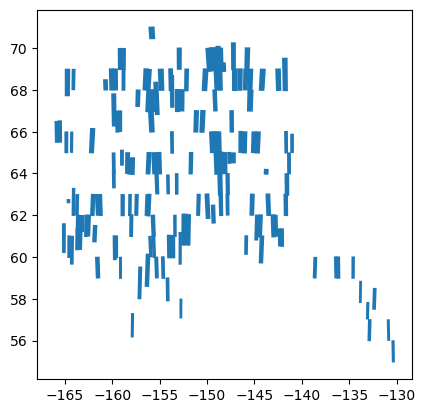

In [13]:
footprint_gdf_sr.plot()

#### Footprint GLiHT archive

In [5]:
out_gliht_fn = '/explore/nobackup/people/pmontesa/userfs02/arc/_footprints/footprints_gliht_13m_p50.gpkg'

# Footprint the p50 across the GLiHT archive
r_fn_list = glob.glob('/explore/nobackup/people/wcwagne1/data/gliht/_tifs/_unzipped/*p50.tif')[0:20]

f_gdf_lst = [raster_footprint(r_fn, DO_DATAMASK=True, GET_ONLY_DATASETMASK=False, R_READ_MODE='r', MANY_CRS=True, DISSOLVE_FIELD='file') for r_fn in r_fn_list]
footprint_gdf = build_footprint_db(f_gdf_lst, TO_GCS=False, WRITE_GPKG=False, OUT_F_NAME=out_gliht_fn, OUT_LYR_NAME='p50')
footprint_gdf.head()

Building GDF from list...


,file,geometry,path,area_km2,area_ha
0,Acadia_Jun2015_l0s0_all_p50.tif,"MULTIPOLYGON (((-68.59541 44.06385, -68.59525 ...",/explore/nobackup/people/wcwagne1/data/gliht/_...,0.240994,24.0994
1,Acadia_Jun2015_l1s0_all_p50.tif,"POLYGON ((-68.36855 44.38553, -68.36790 44.385...",/explore/nobackup/people/wcwagne1/data/gliht/_...,4.364763,436.4763
2,Acadia_Jun2015_l2s0_all_p50.tif,"POLYGON ((-68.36246 44.38295, -68.36230 44.382...",/explore/nobackup/people/wcwagne1/data/gliht/_...,3.396224,339.6224
3,Acadia_Jun2015_l3s0_all_p50.tif,"MULTIPOLYGON (((-68.30532 44.31297, -68.30548 ...",/explore/nobackup/people/wcwagne1/data/gliht/_...,3.531593,353.1593
4,Acadia_Jun2015_l4s0_all_p50.tif,"MULTIPOLYGON (((-68.24274 44.30678, -68.24258 ...",/explore/nobackup/people/wcwagne1/data/gliht/_...,2.506439,250.6439


<AxesSubplot: >

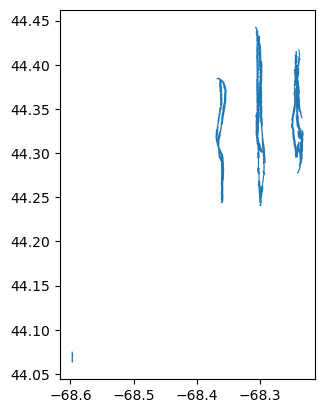

In [6]:
footprint_gdf.plot()

In [28]:
footprint_gdf.cx[-180:180, 50:90].to_crs(3857).to_file('/explore/nobackup/people/pmontesa/userfs02/arc/_footprints/footprints_gliht_13m_p50_3857_alaska.gpkg', driver='GPKG')

In [ ]:
footprint_gdf.cx[-180:180, 0:50].to_crs(3857).to_file('/explore/nobackup/people/pmontesa/userfs02/arc/_footprints/footprints_gliht_13m_p50_3857_notalaska.gpkg', driver='GPKG')

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -10001.0, 'width': 5761, 'height': 5753, 'count': 4, 'crs': CRS.from_epsg(32603), 'transform': Affine(2.0, 0.0, 533855.0,
       0.0, -2.0, 7171745.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}
Fill value: 1e+20
<generator object <genexpr> at 0x1532ec587580>
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   geometry      1 non-null      geometry
 1   raster_value  1 non-null      float64 
dtypes: float64(1), geometry(1)
memory usage: 144.0 bytes
None


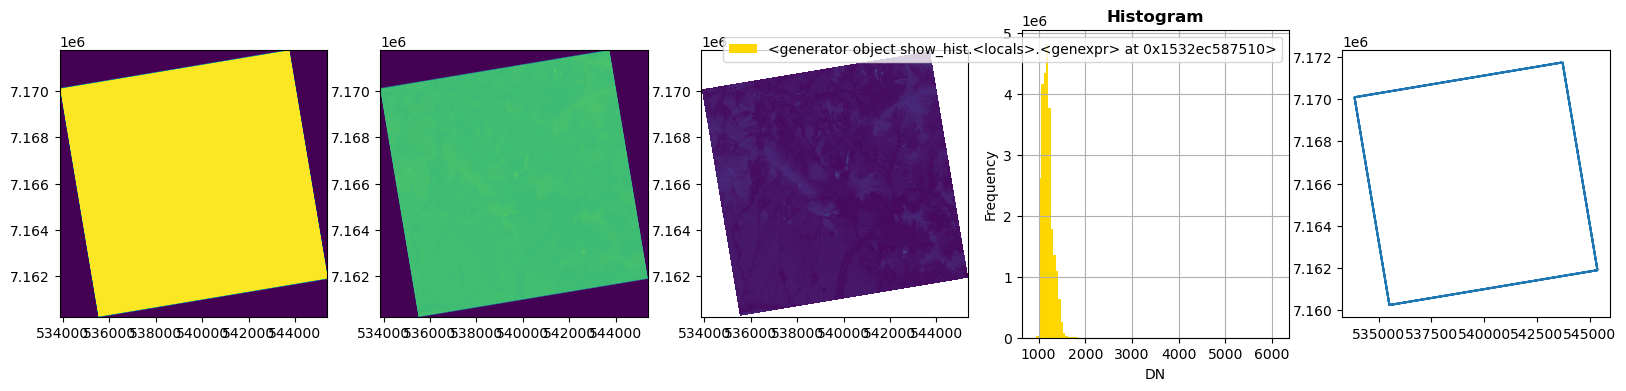

In [9]:
from matplotlib import pyplot
from rasterio.plot import show, show_hist
import numpy as np

ndv = -9999

f,axa = plt.subplots(1,5, sharey=False, sharex=False, figsize=(20,4))

raster_fn = '/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs/data/vhr/WV02_20120721_M1BS_103001001AB23900-toa_sub.tif'
#raster_fn = '/panfs/ccds02/nobackup/projects/ilab/projects/srlite/input/Alaska/WV02_20180912_M1BS_1030010082C72A00-toa.tif'
#raster_fn = r_fn_list[0]

with rasterio.open(raster_fn) as dataset:
    print(dataset.profile)
    new_meta = dataset.profile
    #new_meta.update({'nodata': np.nan})
    #print(new_meta)
    #geom = footprintlib.get_geom_from_datasetmask(dataset, GET_ONLY_DATASETMASK=False)
    #geom[0]

    #msk = dataset.read_masks()
    #msk[msk=0]=np.nan
    show(dataset.read_masks(1), ax=axa[0], transform=dataset.transform)

    # 2
    #arr = dataset.read(1)

    #arr[arr==0.0] = np.nan
    #ma = np.ma.masked_invalid(arr)
    #ma = np.ma.fix_invalid(arr)
    ma = np.ma.masked_invalid(dataset.read(1))
    if dataset.profile['nodata'] is not None:
        ma = np.ma.masked_where(ma == dataset.profile['nodata'], ma)
    #ma = np.ma.masked_array(arr)
    #ma = np.ma.masked_where(arr<0,np.nan, arr)
    #print(repr(ma))
    print(f'Fill value: {ma.fill_value}')
    show(np.ma.getdata(ma), ax=axa[1], transform=dataset.transform)
    #print(ma.data)
    #print(ma.mask)
    show(ma, ax=axa[2], transform=dataset.transform)
    show_hist(ma, ax=axa[3], bins=100)

    #geom = get_geom_from_datasetmask(dataset, GET_ONLY_DATASETMASK=False)
    # This works, but its bounds
    #results = ({'properties': {'raster_value': v}, 'geometry': s} for i, (s, v) in enumerate(rasterio.features.shapes(np.ma.getdata(ma), transform=dataset.transform)) )
    # This works, but its raster value polygons -- too detailed
    #results = ({'properties': {'raster_value': v}, 'geometry': s} for i, (s, v) in enumerate(rasterio.features.shapes(ma, transform=dataset.transform)) )
    
    # Recode valid data to 1 
    ma[ma!=np.nan]=1
    #print(repr(ma))
    results = ({'properties': {'raster_value': v}, 'geometry': s} for i, (s, v) in enumerate(rasterio.features.shapes(ma, transform=dataset.transform)) )
    print(results)    
    geom = list(results)
    footprints_gdf  = gpd.GeoDataFrame.from_features(geom, crs=dataset.crs)
    footprints_gdf.boundary.plot(ax=axa[4])
    print(footprints_gdf.info())

## Build a dictionary of the raster datasets for footprinting

In [17]:
dict_list = [
    # TerraPulse unclipped annual boreal TCC
    {'location':'s3',  #'local' or 's3'
     'data_dir': "s3://terrapulse-pub-data",
     's3_url_prefix': None,
     'data_source': 'terrapulse-pub-data',
     'image_type': 'boreal-tcc-unclipped', 
     'search_tail_string': '/data/**/*y2019_dat.tif', # the year here can vary between 1984-2020; tiles should be exactly the same
     'search_link_string': '',
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'out_footprint_dir': '/efs/projects/forest_height',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': '/efs/pmontesa/credentials'
    },
    {'location':'s3',  #'local' or 's3'
     'data_dir': "s3://terrapulse-pub-data/boreal-forest-data",
     's3_url_prefix': None,
     'data_source': 'terrapulse-pub-data',
     'image_type': 'forest_loss',#'tcc_pvalue',#'tcc_slope', #'tcc_2020', tcc_pvalue, forest_age, forest_loss
     'search_tail_string': '/**/*.tif',
     'search_link_string': '',
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'out_footprint_dir': '/efs/projects/forest_height',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': '/efs/pmontesa/credentials'
    },
    {'location':'local', #'local' or 's3'
     'data_dir': "/efs/projects/data/hls_tiles",
     's3_url_prefix': None,
     'data_source': 'hls_tiles',
     'image_type': 'boreal_tiles_v0003',
     'search_tail_string': '/*.tif',
     'search_link_string': '',
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'out_footprint_dir': '/efs/projects/forest_height/test_out',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    },
    {'location':'local', #'local' or 's3'
     'data_dir': "/att/nobackup/pmontesa/userfs02/data/worldclim/1km/bioclim",
     's3_url_prefix': None,
     'data_source': 'worldclim',
     'image_type': 'wc2.0_30s_bio',
     'search_tail_string': '/wc2.0_bio_30s*.tif',
     'search_link_string': '',
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'out_footprint_dir': '/att/nobackup/pmontesa/userfs02/projects/ilab/boreal_height',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    },   
    {'location':'local', #'local' or 's3'
     'data_dir': "/att/nobackup/pmontesa/userfs02/data",
     's3_url_prefix': None,
     'data_source': 'soil_grids',
     'image_type': 'soil_grids',
     'search_tail_string': '/*.tif',
     'search_link_string': '',
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'out_footprint_dir': '/att/nobackup/pmontesa/userfs02/projects/ilab/boreal_height',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    }, 
    {'location':'local', #'local' or 's3'
     'data_dir': "/att/nobackup/pmontesa/userfs02/data",
     's3_url_prefix': None,
     'data_source': 'awi',
     'image_type': 'MAGT',
     'search_tail_string': '/*PERPROB*.tif',
     'search_link_string': '',
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'out_footprint_dir': '/att/nobackup/pmontesa/userfs02/projects/ilab/boreal_height',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    },    
    {'location': 'local',
     'data_dir': "/adapt/nobackup/projects/ilab/scratch/jli30/data/boreal_forest",
     's3_url_prefix': None,
     'data_source': 'modis_trend',
     'image_type': 'modis_trend',
     'search_tail_string': '/*peak.bias.tif',
     'search_link_string': '',
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'out_footprint_dir': '/att/nobackup/pmontesa/userfs02/projects/ilab/boreal_height',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    },
    {'location': 'local',
     'data_dir': '/adapt/nobackup/people/pmontesa/userfs02/projects/ilab/boreal_height/data',#"/adapt/nobackup/projects/ilab/scratch/jli30/data/boreal_forest",
     's3_url_prefix': None,
     'data_source': 'modis_trend',
     'image_type': 'modis_trend',
     'search_tail_string': '/*peak.bias_reprj-4326.tif',
     'search_link_string': '',
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'out_footprint_dir': '/adapt/nobackup/people/pmontesa/userfs02/projects/ilab/boreal_height/data/modis_trend',#'/att/nobackup/pmontesa/userfs02/projects/ilab/boreal_height',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    },
    {'location': 's3',
     'data_dir': "s3://esa-worldcover",
     's3_url_prefix': "https://esa-worldcover.s3.eu-central-1.amazonaws.com",
     'data_source': 'v100/2020',
     'image_type': 'v100/2020/map',
     'search_tail_string': '/*Map.tif',
     'search_link_string': '',
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'out_footprint_dir': '/efs/projects/forest_height',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    },
    # Eurasia establishment year v2
    {'location': 'local',
     'data_dir': '/adapt/nobackup/people/pmontesa/userfs02/data/standage',
     's3_url_prefix': None,
     'data_source': 'esta_year_n0_m1',
     'image_type': 'boreal_ea/tiles',
     'search_tail_string': '/*esta_year_n0_m1.tif',
     'search_link_string': '',
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'out_footprint_dir': '/adapt/nobackup/people/pmontesa/userfs02/data/standage',#'/att/nobackup/pmontesa/userfs02/projects/ilab/boreal_height',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    },
    # NA establishment year v2
    {'location': 'local',
     'data_dir': '/adapt/nobackup/people/pmontesa/userfs02/data/standage',
     's3_url_prefix': None,
     'data_source': 'esta_year_n0_m1',
     'image_type': 'boreal_na/tiles',
     'search_tail_string': '/*esta_year_n0_m1.tif',
     'search_link_string': '',
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'out_footprint_dir': '/adapt/nobackup/people/pmontesa/userfs02/data/standage',#'/att/nobackup/pmontesa/userfs02/projects/ilab/boreal_height',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    },
    # NA establishment year v2 MMU version
    {'location': 'local',
     'data_dir': '/adapt/nobackup/people/pmontesa/userfs02/data/standage',
     's3_url_prefix': None,
     'data_source': 'esta_year_n0_m1h2',
     'image_type': 'boreal_na/mmu/esta_year_tiles',
     'search_tail_string': '/*esta_year_n0_m1h2.tif',
     'search_link_string': '',
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'out_footprint_dir': '/adapt/nobackup/people/pmontesa/userfs02/data/standage',#'/att/nobackup/pmontesa/userfs02/projects/ilab/boreal_height',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    },
    # 3SL Senegal TOAs: /explore/nobackup/projects/3sl/data/VHR
    {'location': 'local',
     'data_dir': '/explore/nobackup/projects/3sl/data',
     'data_source': '3sl',
     'image_type': 'VHR',
     'search_tail_string': '/**/*M1BS*toa.tif',
     'search_link_string': '',
     'GET_BATCH': True,
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'MANY_CRS': True,
     'out_footprint_dir': '/explore/nobackup/people/pmontesa/userfs02/projects/LULC_Senegal', #'/adapt/nobackup/projects/ilab/projects/srlite/input',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    },
    # AGB ref tiles
    {'location': 'local',
     'data_dir': '/home/pmontesa/code/geoscitools',
     'data_source': 'norway_ref',
     'image_type': 'norway_test_agb_tiles',
     'search_tail_string': '/*.tif',
     'search_link_string': '',
     'GET_BATCH': True,
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'MANY_CRS': True,
     'out_footprint_dir': '/home/pmontesa/code/geoscitools/norway_test_agb_tiles', #'/adapt/nobackup/projects/ilab/projects/srlite/input',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    },
    
    # 3SL Senegal Tappan CHMs: /explore/nobackup/projects/3sl/data/VHR
    {'location': 'local',
     'data_dir': '/explore/nobackup/projects/ilab/projects/AIML_CHM/CNN_CHM/products/senegal/v2',
     'data_source': '3sl',
     'image_type': 'Tappan',
     'search_tail_string': '/*2m_chm.tif',
     'search_link_string': '',
     'GET_BATCH': True,
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'MANY_CRS': True,
     'out_footprint_dir': '/explore/nobackup/projects/ilab/projects/AIML_CHM/CNN_CHM/products/senegal/v2', #'/adapt/nobackup/projects/ilab/projects/srlite/input',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    },
    # GLiHT tree_fcover

]

In [4]:
if False:
    for d in dict_list:
        print('\n', d['data_source'])

        if d['location'] == 's3':
            import s3fs
            # Use s3fs to access file remote s3 system
            s3 = footprintlib.get_s3_fs_from_creds('/home/pmontesa/credentials_test') # '/efs/pmontesa/credentials'
            print(s3.ls(d['data_dir']))

### Run the footprinting code over an s3 datalist to return and geodataframe and a geopackage **updated** 

https://stackoverflow.com/questions/67812512/rasterio-does-not-exist-in-the-file-system-and-is-not-recognized-as-a-support

In [10]:
######################
# Select a dictionary
d = dict_list[-1]
TEST=False
TEST_SIZE=100
CHUNK=False
CHUNK_SIZE=5000
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
######################
d

{'location': 'local',
 'data_dir': '/explore/nobackup/projects/ilab/projects/AIML_CHM/CNN_CHM/products/senegal/v2',
 'data_source': '3sl',
 'image_type': 'Tappan',
 'search_tail_string': '/*2m_chm.tif',
 'search_link_string': '',
 'GET_BATCH': True,
 'DO_DATAMASK': False,
 'GET_ONLY_DATASETMASK': True,
 'MANY_CRS': True,
 'out_footprint_dir': '/explore/nobackup/projects/ilab/projects/AIML_CHM/CNN_CHM/products/senegal/v2',
 'footprint_name_SPLIT_CHAR': '_',
 'footprint_name_SPLIT_POS': 0,
 'aws_credential_fn': None}

### Run the footprinting code over a list  
return:
1. a geodataframe  
2. a geopackage **updated** 

notes:  
https://stackoverflow.com/questions/67812512/rasterio-does-not-exist-in-the-file-system-and-is-not-recognized-as-a-support

In [11]:
%%time

footprint_gdf_list = list()

# Below - chunk number appended to end
filename = 'footprints_' + d['data_source'].replace('/','_')+'_'+d['image_type'].replace('/','_') #+'.gpkg'

#SEARCH_STR_LIST = ["/", sensor, image_type, ".tif"]
SEARCH_STR_LIST = ["/", d['image_type'], d['search_tail_string']]
keystring = d['search_link_string'].join(SEARCH_STR_LIST)
print(d['data_dir'] + keystring)

# Build raster filename list
if d['location'] == 'local':
    r_fn_list = glob.glob(d['data_dir'] + keystring, recursive=True)
    
if d['location'] == 's3':
    print('on s3...')
    if d['aws_credential_fn'] is None:
        s3 = get_s3_fs_from_creds(anon=True)
    else:
        s3 = get_s3_fs_from_creds(credentials_fn=d['aws_credential_fn'])
    r_fn_list = s3.glob(d['data_dir'] + keystring)
    r_fn_list = ['s3://' + f for f in r_fn_list]

if TEST:
    print(f'Test size: {TEST_SIZE}')
    r_fn_list = r_fn_list[0:TEST_SIZE]
    print(f'Show first 5 rasters in list:\n{r_fn_list[0:5]}')
    filename = 'TEST_' + filename

print(f'{len(r_fn_list)} total inputs from ' + d['data_source'] )    

# Set up a list of raster filename lists to handle chunking if true
if CHUNK:
    print(f'Chunk size: {CHUNK_SIZE}')
    LIST_CHUNKS_r_fn_list = chunks(r_fn_list, CHUNK_SIZE)
else:
    LIST_CHUNKS_r_fn_list = [r_fn_list]

# Loop over chunks
for r_fn_list_idx, r_fn_list in enumerate(LIST_CHUNKS_r_fn_list):
    if CHUNK:
        outprint_fn = os.path.join(d['out_footprint_dir'], filename + f'_chunk{r_fn_list_idx+1:03}'+'.gpkg')
    else:
        outprint_fn = os.path.join(d['out_footprint_dir'], filename.strip('_') + '.gpkg')

    # Get list of geodataframes of individual raster footprints 
    #
    if d['location'] == 'local':
        # Raster files are local
        # Get a list geodataframes of indiv raster footprint geometries (both data and mask)
        f_gdf_lst = [raster_footprint(r_fn, DO_DATAMASK=d['DO_DATAMASK'], GET_ONLY_DATASETMASK=d['GET_ONLY_DATASETMASK'], R_READ_MODE='r') for r_fn in r_fn_list]

    if d['location'] == 's3':
        # Raster files are on s3
        # Get the rio AWS session needed to access the s3 rasters in order to footprint
        if d['aws_credential_fn'] is None:
            if d['s3_url_prefix'] is not None:
                # This doesnt work
                #f_gdf_lst = [raster_footprint(s3.open(r_fn, mode = 'r'), DO_DATAMASK=d['DO_DATAMASK'], GET_ONLY_DATASETMASK=d['GET_ONLY_DATASETMASK'], R_READ_MODE='r') for r_fn in r_fn_list]
                r_fn_list = [f.replace(d['data_dir'], d['s3_url_prefix']) for f in r_fn_list]
            f_gdf_lst = [raster_footprint(r_fn, DO_DATAMASK=d['DO_DATAMASK'], GET_ONLY_DATASETMASK=d['GET_ONLY_DATASETMASK'], R_READ_MODE='r') for r_fn in r_fn_list]
        else:
            aws_session = get_rio_aws_session_from_creds(d['aws_credential_fn'])
            with rio.Env(aws_session):
                # Get a list geodataframes of indiv raster footprint geometries (both data and mask)
                f_gdf_lst = [raster_footprint(r_fn, DO_DATAMASK=d['DO_DATAMASK'], GET_ONLY_DATASETMASK=d['GET_ONLY_DATASETMASK'], R_READ_MODE='r') for r_fn in r_fn_list]

    if len(f_gdf_lst)==0:
        print('\nNothing was footprinted.\n')
    else:
        # Build a footprint database geodataframe from all individual raster footprints
        footprint_gdf = build_footprint_db(f_gdf_lst, TO_GCS=False, WRITE_GPKG=True, OUT_F_NAME=outprint_fn, OUT_LYR_NAME=d['image_type'])

        # depracating this part
        footprint_gdf['footprint_name'] = footprint_gdf['file'].str.split(d['footprint_name_SPLIT_CHAR'], expand=True)[d['footprint_name_SPLIT_POS']]
        footprint_gdf_list.append(footprint_gdf)


/explore/nobackup/projects/ilab/projects/AIML_CHM/CNN_CHM/products/senegal/v2/Tappan/*2m_chm.tif
327 total inputs from 3sl
Building GDF from list...
Wrote out spatial footprints to /explore/nobackup/projects/ilab/projects/AIML_CHM/CNN_CHM/products/senegal/v2/footprints_3sl_Tappan.gpkg
CPU times: user 2.01 s, sys: 470 ms, total: 2.48 s
Wall time: 8.33 s


In [54]:
footprint_gdf['local_path'] = '/projects/shared-buckets/lduncanson/norway_test_data/' + footprint_gdf['file']
footprint_gdf['id'] = footprint_gdf['file'].str.split('_', expand=True)[1].str.strip('*.tif').astype(int)
footprint_gdf = footprint_gdf.to_crs(4326)
footprint_gdf.crs
footprint_gdf.to_file('/home/pmontesa/code/geoscitools/norway_test_agb_tiles/footprints_norway_ref_AGB_tiles.gpkg', driver='GPKG', layer='footprints_norway_ref_AGB_tiles')

In [37]:
print(d['data_dir'] + keystring)
glob.glob('/explore/nobackup/projects/3sl/data/VHR/**/**/*M1BS*toa.tif')

/explore/nobackup/projects/3sl/data/VHR/**/*M1BS*toa.tif


['/explore/nobackup/projects/3sl/data/VHR/CAS/M1BS/WV02_20101031_M1BS_103001000720F800-toa.tif',
 '/explore/nobackup/projects/3sl/data/VHR/CAS/M1BS/WV02_20110317_M1BS_1030010009A95F00-toa.tif',
 '/explore/nobackup/projects/3sl/data/VHR/CAS/M1BS/WV02_20200615_M1BS_10300100A8B6BF00-toa.tif',
 '/explore/nobackup/projects/3sl/data/VHR/CAS/M1BS/WV02_20121218_M1BS_103001001D773D00-toa.tif',
 '/explore/nobackup/projects/3sl/data/VHR/CAS/M1BS/WV02_20140124_M1BS_103001002BC1CB00-toa.tif',
 '/explore/nobackup/projects/3sl/data/VHR/CAS/M1BS/WV02_20151225_M1BS_103001004FC2BD00-toa.tif',
 '/explore/nobackup/projects/3sl/data/VHR/CAS/M1BS/WV02_20141110_M1BS_103001003AA46B00-toa.tif',
 '/explore/nobackup/projects/3sl/data/VHR/CAS/M1BS/WV02_20141129_M1BS_103001003B0A5F00-toa.tif',
 '/explore/nobackup/projects/3sl/data/VHR/CAS/M1BS/WV02_20121014_M1BS_103001001B793900-toa.tif',
 '/explore/nobackup/projects/3sl/data/VHR/CAS/M1BS/WV02_20190127_M1BS_103001008ABC2C00-toa.tif',
 '/explore/nobackup/projects/3

In [26]:
# Concat chunks and write full file
print('Concatenating all chunks into a single gdf and saving...')
footprint_gdf = pd.concat(footprint_gdf_list)

if 'boreal-tcc-unclipped' in d['image_type']:
    print('Overriding CRS...')
    import pyproj
    # This comes from the dataset.profile of one of the raster tiles
    crs_sin = pyproj.crs.CRS.from_wkt('PROJCS["unnamed",GEOGCS["unnamed ellipse",DATUM["unknown",SPHEROID["unnamed",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')
    
    footprint_gdf = footprint_gdf.set_crs(crs_sin, allow_override=True)
    
# Make a 'tile_num' field based on index
footprint_gdf['tile_num'] = footprint_gdf.index

# Make an s3_path field with full filename path
footprint_gdf["s3_path"] = footprint_gdf[['path', 'file']].apply(lambda row: os.path.join(*row), axis=1)

print(f"Saving concatenated footprint to: {os.path.join(d['out_footprint_dir'], filename +'.gpkg')}") 
footprint_gdf.to_file(os.path.join(d['out_footprint_dir'], filename +'.gpkg'), driver='GPKG')                     

Concatenating all chunks into a single gdf and saving...
Saving concatenated footprint to: /adapt/nobackup/people/pmontesa/userfs02/data/standage/footprints_esta_year_n0_m1_boreal_ea_tiles.gpkg


#### Test access to rasters on s3

In [50]:
footprint_gdf["s3_path"] = footprint_gdf[['path', 'file']].apply(lambda row: os.path.join(*row).replace('y2019','y1999'), axis=1)
footprint_gdf.s3_path.to_list()[0]

's3://terrapulse-pub-data/boreal-tcc-unclipped/data/h1000/v084/h1000v084/h1000v084_y1999_dat.tif'

s3://terrapulse-pub-data/boreal-tcc-unclipped/data/h991/v145/h991v145/h991v145_y2009_dat.tif
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 801, 'height': 801, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["unnamed ellipse",DATUM["unknown",SPHEROID["unnamed",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, 3768890.6442025825,
       0.0, -30.0, 6527554.677898709), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


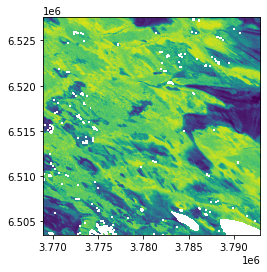

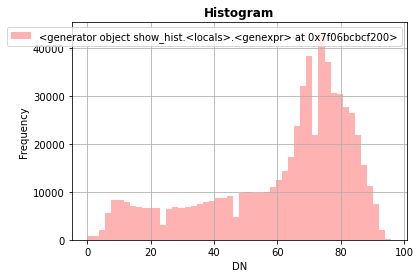

In [48]:
r_fn = r_fn_list[1000].replace('y2019','y2009')
print(r_fn)
with rasterio.Env(AWS_NO_SIGN_REQUEST='YES'):
    with rasterio.open(r_fn, mode='r') as dataset:
        print(dataset.profile)
        from rasterio.plot import show_hist
        import contextily as ctx
        show(dataset)
        
        show_hist(
            dataset, bins=50, lw=0.0, stacked=False, alpha=0.3,
            histtype='stepfilled', title="Histogram")

### Select the footprints gdf

In [41]:
footprint_gdf = footprint_gdf_list[0]
#print(footprint_gdf.path.to_list())
#print(footprint_gdf.to_crs(4326).iloc[1])
#print(footprint_gdf.iloc[1])
#footprint_gdf[footprint_gdf.file=='MCD12Q2.h12v02.peak.bias.tif'].to_crs(4326).geometry.to_json()
#footprint_gdf.crs.to_json()

## Map the footprints

In [ ]:
#maplib.MAP_LAYER_FOLIUM(footprint_gdf.iloc[[3,5]], zoom_start=2)
maplib.MAP_LAYER_FOLIUM(footprint_gdf, LAYER_COL_NAME='file', zoom_start=2, lon_start=0)

### Check terrapulse stand age footprints

In [6]:
f_fn = '/efs/projects/forest_height/footprints_terrapulse-pub-data_forest_age_v2.gpkg'
import fiona
print(fiona.listlayers(f_fn))

f_age_gdf = gpd.read_file(f_fn, layer=fiona.listlayers(f_fn)[0])
maplib.MAP_LAYER_FOLIUM(f_age_gdf, LAYER_COL_NAME='path', zoom_start=2, lon_start=0)

['forest_age']


/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


### Manually check footprint for a single image

In [30]:
r_fn = '/att/nobackup/pmontesa/userfs02/data/MAGT/UiO_PEX_PERPROB_3.0_20171201_2000_2016.tif'
r_fn = '/att/nobackup/pmontesa/userfs02/data/soil_grids/CECSOL_M_sl2_250m_ll.tif'
r_fn = '/att/nobackup/pmontesa/userfs02/data/worldclim/1km/bioclim/wc2.0_30s_bio/wc2.0_bio_30s_01.tif'
footprint_gdf = raster_footprint(r_fn, DO_DATAMASK=d['DO_DATAMASK'], GET_ONLY_DATASETMASK=d['GET_ONLY_DATASETMASK'], R_READ_MODE='r+')
maplib.MAP_LAYER_FOLIUM(footprint_gdf, LAYER_COL_NAME='path', zoom_start=2, lon_start=0)